In [ ]:
# Importations des librairies
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import re
import os

# Pour la modélisation
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.metrics import ConfusionMatrixDisplay


# Chargement des données avec exception pour les fichiers non trouvés
try:
    df_train_raw = pd.read_csv('data/train.csv')
    df_test_raw = pd.read_csv('data/test.csv')
    print("Fichiers chargés avec succès.")
except FileNotFoundError:
    raise SystemExit("Fichiers de données non trouvés.")

# Fonction Affichage des principales infos sur les jeux de données
def display_info(df):
    print('')
    print('******Info******')
    df.info()
    print('')
    print('******Description******')
    print(df.describe())
    print('')
    print('******Head******')
    print(df.head(5))
    print('')
    print('******Valeurs manquantes******')
    print(df.isnull().sum())
    print('')
    print('******Types******')
    print(df.dtypes)
    print('')
    print('******Colonnes******')
    print(df.columns)
    
    return

# Affichage des principales infos sur le jeu de données
print('******TRAIN******')
display_info(df_train_raw)
print('')
print('******TEST******')
display_info(df_test_raw)

Fichiers chargés avec succès.
******TRAIN******

******Info******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

******Description******
       PassengerId    Survived      Pclass         Age       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  714.000000  891.00

In [2]:
# Création d'une copie des df
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

In [3]:
# Fonction Extraction et regroupement des titres
def extract_and_group_titles(df):
    df = df.copy()
    df['Title'] = df['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(
        ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],
        'Rare'
    )
    df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

    return df

In [4]:
# Fonction Création de nouvelles features
def new_features(df):
    df = df.copy()

    # Création colonne 'Accompanied' 1 = oui et 0 = non
    df['Accompanied'] = ((df['SibSp'] + df['Parch']) > 0).astype(int)

    # # Garder 'Sex' lisible pour les graphes
    # df['Sex_label'] = df['Sex']

    # Traitement des valeurs manquantes de 'Fare' avant l'encodage de Pclass/Embarked
    if df['Fare'].isnull().any():
        for idx in df[df['Fare'].isnull()].index:
            ticket = df.loc[idx, 'Ticket']
            fare_match = df[df['Ticket'] == ticket]['Fare'].dropna()
            if not fare_match.empty:
                df.at[idx, 'Fare'] = fare_match.iloc[0]
            else:
                # Utilisation de 'Pclass' brut et 'Embarked' brut
                pclass = df.loc[idx, 'Pclass']
                embarked = df.loc[idx, 'Embarked']
                median_fare = df[(df['Pclass'] == pclass) & (df['Embarked'] == embarked)]['Fare'].median()
                df.at[idx, 'Fare'] = median_fare

    return df


In [5]:
# Fonction Calcul médiane et Création du dictionnaire d'imputation avec Titre
def compute_median_age_title(df):
    median_age_title = df.groupby(['Title', 'Pclass', 'Sex', 'Accompanied'])['Age'].median()

    # Création du dictionnaire d'imputation
    median_age_title_dict = {}
    for title in df['Title'].unique():
        for pclass in df['Pclass'].unique():
            for sex in df['Sex'].unique():
                for accompanied in df['Accompanied'].unique():
                    key = (title, pclass, sex, accompanied)
                    if key in median_age_title.index and pd.notna(median_age_title[key]):
                        median_age_title_dict[key] = median_age_title[key]
    return median_age_title, median_age_title_dict

# Fonction Calcul médiane et Création du dictionnaire d'imputation sans Titre 
def compute_median_age(df):
    median_age = df.groupby(['Sex', 'Pclass', 'Accompanied'])['Age'].median()

    # Création du dictionnaire d'imputation
    median_age_dict = {}
    for sex in df['Sex'].unique():
        for pclass in df['Pclass'].unique():
            for accompanied in df['Accompanied'].unique():
                key = (sex, pclass, accompanied)
                if key in median_age.index and pd.notna(median_age[key]):
                    median_age_dict[key] = median_age[key]
    return median_age, median_age_dict


In [6]:
# Fonction d'imputation de l'âge selon les fonctions median_age et median_age_title
def impute_age(row, median_age_title_dict, median_age_dict):
    if pd.notna(row['Age']):    # Si 'Age' n'est pas null, on le laisse intact
        return row['Age']

    key_title = (row['Title'], row['Pclass'], row['Sex'], row['Accompanied'])   # Création des clés pour le dictionnaire d'imputation
    key_no_title = (row['Sex'], row['Pclass'], row['Accompanied'])

    if key_title in median_age_title_dict:   # Si la clé est dans le dictionnaire d'imputation, on l'utilise. Sinon, on utilise l'autre médiane
        return median_age_title_dict[key_title]
    else:
        return median_age_dict[key_no_title]


In [7]:
def encode_features(df):
    
    # Encodage de 'Sex'
    df['Sex'] = (df['Sex'] == 'male').astype(int)

    # Encodage de 'Pclass' et 'Title'
    df = pd.get_dummies(df, columns=['Pclass', 'Title'], drop_first=False)

    # Remplissage des NaN et Encodage de 'Embarked'
    df['Embarked'] = df['Embarked'].fillna('C')
    df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked', drop_first=False)
    
    return df

In [8]:
# Fonction Nettoyage des données finales
def clean_final_data(df, is_train=True):
    df = df.copy()

    # Supprimer les colonnes inutiles pour la modélisation
    columns_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']

    # Pour le test, on garde 'PassengerId' pour la soumission
    if not is_train:
        columns_drop.remove('PassengerId')

    df = df.drop(columns=[col for col in columns_drop if col in df.columns])

    return df

In [9]:
# Fonction de verification finale des données
def verify_data(df_train, df_test):
    print("=== VÉRIFICATION FINALE ===")
    
    # Vérifier les valeurs manquantes
    print("\n--- Valeurs manquantes ---")
    print("Train:", df_train.isnull().sum().sum())
    print("Test:", df_test.isnull().sum().sum())
    
    # Vérifier les colonnes
    train_cols = set(df_train.columns)
    test_cols = set(df_test.columns)
    
    print(f"\n--- Colonnes ---")
    print(f"Train: {len(train_cols)} colonnes")
    print(f"Test: {len(test_cols)} colonnes")
    
    # Colonnes différentes
    only_train = train_cols - test_cols
    only_test = test_cols - train_cols
    
    if only_train:
        print(f"Seulement dans train: {only_train}")
    if only_test:
        print(f"Seulement dans test: {only_test}")
    
    # Vérifier les types
    print(f"\n--- Types de données ---")
    print("Train dtypes:")
    print(df_train.dtypes)
    print("\nTest dtypes:")
    print(df_test.dtypes)

    return len(only_train) == 1 and 'Survived' in only_train

In [10]:
# Fonction Pipeline complète

def pipeline(df_train_raw, df_test_raw):

    print('*********** DEBUT DU PIPELINE*************')

    # Copie des df
    df_train = df_train_raw.copy()
    df_test = df_test_raw.copy()

    # Extraction des titres
    df_train = extract_and_group_titles(df_train)
    df_test = extract_and_group_titles(df_test)

    # Nouvelles features
    df_train = new_features(df_train)
    df_test = new_features(df_test)

    # Imputation des valeurs manquantes
    median_age_title, median_age_title_dict = compute_median_age_title(df_train)
    median_age, median_age_dict = compute_median_age(df_train)
    df_train['Age'] = df_train.apply(
        lambda row: impute_age(row, median_age_title_dict, median_age_dict), 
        axis=1
    )
    df_test['Age'] = df_test.apply(
        lambda row: impute_age(row, median_age_title_dict, median_age_dict), 
        axis=1
    )

    # Encodage des données
    df_train = encode_features(df_train)
    df_test = encode_features(df_test)

    # Nettoyage finale des données
    df_train_clean = clean_final_data(df_train, is_train=True)
    df_test_clean = clean_final_data(df_test, is_train=False)

    # Vérification des données
    is_valid = verify_data(df_train_clean, df_test_clean)

    if not is_valid:
        raise ValueError("Pipeline invalide, vérifiez les données")
    
    # Préparation final des données
    x = df_train_clean.drop('Survived', axis=1)
    y = df_train_clean['Survived']
    x_test = df_test_clean[df_train_clean.drop('Survived', axis=1).columns]
    passenger_ids = df_test_clean['PassengerId']

    print('*********** FIN DU PIPELINE*************')
    print(f"x shape: {x.shape}, y shape: {y.shape}")
    print(f"x_test shape: {x_test.shape}, passenger_ids shape: {passenger_ids.shape}")

    return x, y, x_test, passenger_ids, df_train_clean, df_test_clean

In [11]:
x, y, x_test, passenger_ids, df_train_clean, df_test_clean = pipeline(df_train_raw, df_test_raw)

*********** DEBUT DU PIPELINE*************
=== VÉRIFICATION FINALE ===

--- Valeurs manquantes ---
Train: 0
Test: 0

--- Colonnes ---
Train: 18 colonnes
Test: 18 colonnes
Seulement dans train: {'Survived'}
Seulement dans test: {'PassengerId'}

--- Types de données ---
Train dtypes:
Survived          int64
Sex               int64
Age             float64
SibSp             int64
Parch             int64
Fare            float64
Accompanied       int64
Pclass_1           bool
Pclass_2           bool
Pclass_3           bool
Title_Master       bool
Title_Miss         bool
Title_Mr           bool
Title_Mrs          bool
Title_Rare         bool
Embarked_C         bool
Embarked_Q         bool
Embarked_S         bool
dtype: object

Test dtypes:
PassengerId       int64
Sex               int64
Age             float64
SibSp             int64
Parch             int64
Fare            float64
Accompanied       int64
Pclass_1           bool
Pclass_2           bool
Pclass_3           bool
Title_Master     

In [12]:
# Fonction d’évaluation avec option de sous-échantillonnage
def evaluate_models(x, y, cv=5, train_size=1.0):
    from sklearn.model_selection import train_test_split

    # Réduction de l'ensemble d'entraînement si train_size < 1.0
    if train_size < 1.0:
        x, _, y, _ = train_test_split(x, y, train_size=train_size, stratify=y, random_state=42)
        print(f"Utilisation de {len(x)} échantillons pour l'entraînement ({train_size*100:.0f}%)")

    models = {
        "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
        "SGD Classifier": make_pipeline(StandardScaler(), SGDClassifier(loss="log_loss", random_state=42)),
        "SVM": make_pipeline(StandardScaler(), SVC(probability=True)),  # probas nécessaires pour log_loss
        "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier()),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    }

    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, model in models.items():
        print(f"Évaluation de {name}...")

        acc_scores = []
        logloss_scores = []

        for train_idx, val_idx in skf.split(x, y):
            x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model_clone = clone(model)
            model_clone.fit(x_train, y_train)

            y_pred = model_clone.predict(x_val)
            y_proba = model_clone.predict_proba(x_val)

            acc_scores.append(accuracy_score(y_val, y_pred))
            logloss_scores.append(log_loss(y_val, y_proba))

        results[name] = {
            "accuracy_mean": np.mean(acc_scores),
            "accuracy_std": np.std(acc_scores),
            "logloss_mean": np.mean(logloss_scores),
            "logloss_std": np.std(logloss_scores)
        }

        print(f"  * Accuracy : {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
        print(f"  -- Log loss : {np.mean(logloss_scores):.4f} ± {np.std(logloss_scores):.4f}")

        # Matrice de confusion
        model_final = clone(model)
        model_final.fit(x, y)
        y_pred_full = model_final.predict(x)

        cm = confusion_matrix(y, y_pred_full)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"Matrice de confusion – {name}")
        plt.grid(False)
        plt.show()

    return results

Évaluation de Logistic Regression...


  * Accuracy : 0.8283 ± 0.0111
  -- Log loss : 0.4117 ± 0.0176


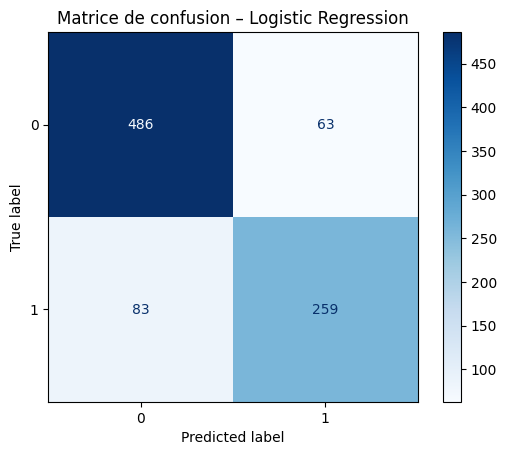

Évaluation de SGD Classifier...
  * Accuracy : 0.7800 ± 0.0209
  -- Log loss : 0.6569 ± 0.0800


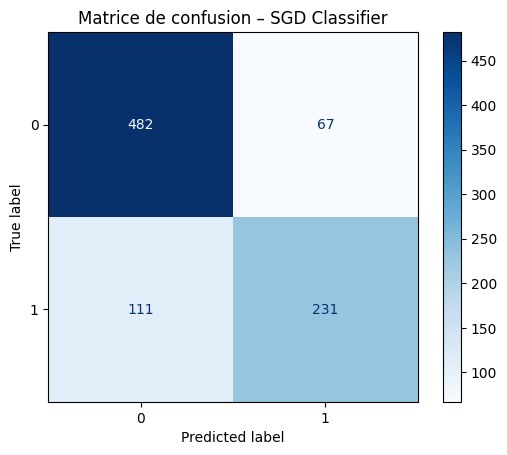

Évaluation de SVM...
  * Accuracy : 0.8260 ± 0.0117
  -- Log loss : 0.4373 ± 0.0177


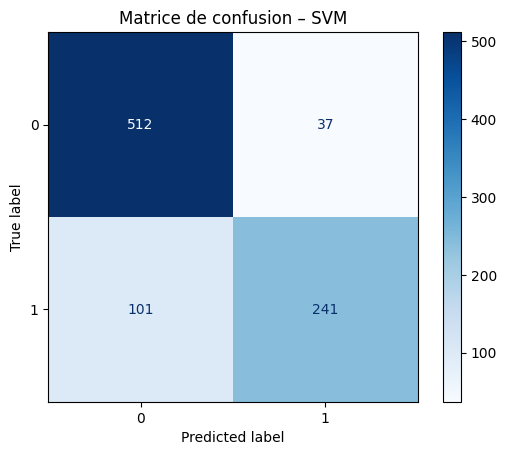

Évaluation de KNN...
  * Accuracy : 0.8081 ± 0.0181
  -- Log loss : 1.9782 ± 0.4496


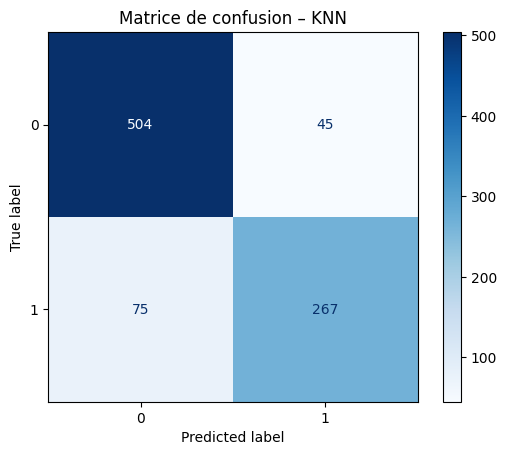

Évaluation de Random Forest...
  * Accuracy : 0.8103 ± 0.0042
  -- Log loss : 0.8508 ± 0.2988


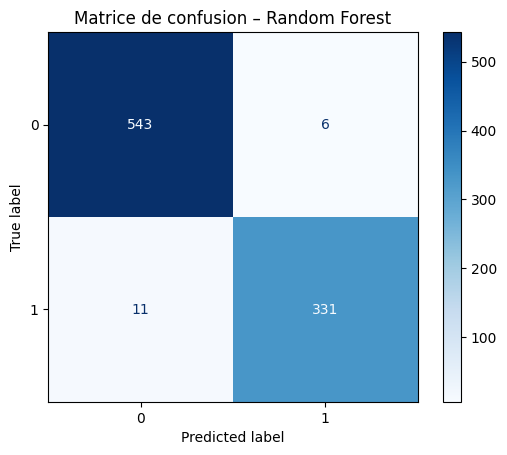

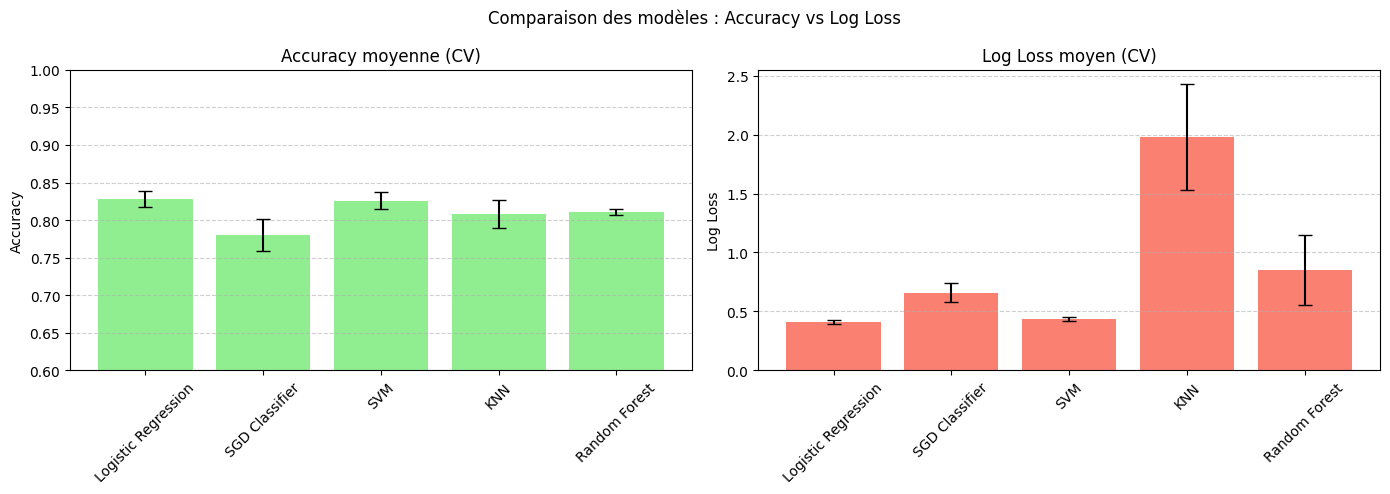

In [13]:
# Fonction affichage des résultats
def plot_results(results):
    model_names = list(results.keys())
    
    accuracies = [results[m]["accuracy_mean"] for m in model_names]
    acc_errors = [results[m]["accuracy_std"] for m in model_names]

    log_losses = [results[m]["logloss_mean"] for m in model_names]
    logloss_errors = [results[m]["logloss_std"] for m in model_names]

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Barres pour accuracy
    ax[0].bar(model_names, accuracies, yerr=acc_errors, capsize=5, color='lightgreen')
    ax[0].set_title("Accuracy moyenne (CV)")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_ylim(0.6, 1.0)
    ax[0].grid(axis='y', linestyle='--', alpha=0.6)

    # Barres pour log_loss
    ax[1].bar(model_names, log_losses, yerr=logloss_errors, capsize=5, color='salmon')
    ax[1].set_title("Log Loss moyen (CV)")
    ax[1].set_ylabel("Log Loss")
    ax[1].grid(axis='y', linestyle='--', alpha=0.6)

    for axes in ax:
        axes.set_xticks(range(len(model_names)))
        axes.set_xticklabels(model_names, rotation=45)

    plt.suptitle("Comparaison des modèles : Accuracy vs Log Loss")
    plt.tight_layout()
    plt.show()
    
# On sélectionne la taille de l'échantillon d'entraînement    
results = evaluate_models(x, y, train_size=1.0)
plot_results(results)

In [14]:
# Entraînement du modèle choisi sur TOUT l'entraînement
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(x, y)

# Prédiction sur les données de test
y_pred = final_model.predict(x_test)


In [15]:
# Génération du fichier CSV pour soumission
def save_csv_submission(passenger_ids, y_pred, filename='submission.csv'):
    filepath = filename
    print(f"Sauvegarde dans : {os.path.abspath(filepath)}")

    submission_df = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Survived': y_pred
    })

    submission_df.to_csv(filepath, index=False)
    print(f"Fichier sauvegardé : {filepath}")
    return filepath

# Création du fichier csv
filepath = save_csv_submission(passenger_ids, y_pred)

Sauvegarde dans : /home/loic/Projets_briefs/titanic/submission.csv
Fichier sauvegardé : submission.csv
